<a href="https://colab.research.google.com/github/OmerNachshon/Titanic---Machine-Learning-from-Disaster-2/blob/main/titanic_survival_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/om3rnach/account , omer nachshon 209006535

# TL;DR
Goal: predict the number of survivors on the Titanic
Approach:
* Replace all non numeric values to numeric values
* Fill/Drop missing values 
* Drop irrelevent features
* Create Additional features from existing features
* Seperate dataset into dependant and independant features 
* Create dummies 
* Split using train_test_split module to train our model
* Use LogisticRegression, BaggingClassifier ,RFClassifier,DecTreeClassifier 
* Model Hyperparameter Optimization with GridSearch
* Choose best model

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
train=pd.read_csv("sample_data/train.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
test=pd.read_csv("sample_data/test.csv")
test.head()
id_col=test['PassengerId']

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


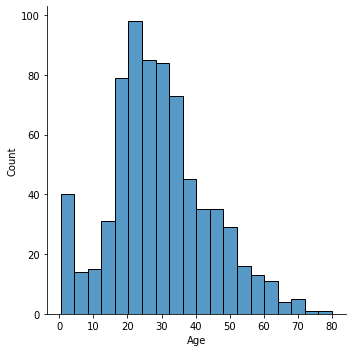

In [ ]:
sns.displot(x='Age', data=train)
plt.show()

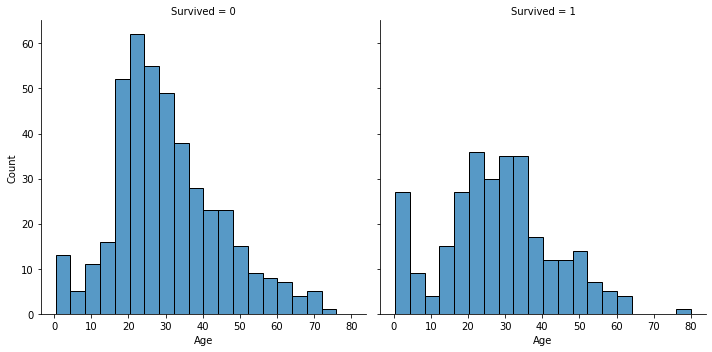

In [ ]:
sns.displot(x='Age', data=train, col='Survived')
plt.show()

In [ ]:
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

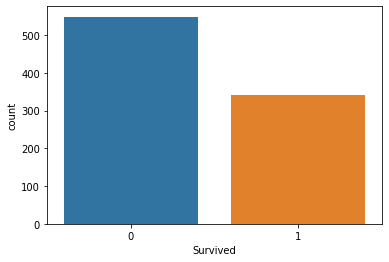

In [ ]:
sns.countplot(data=train,x='Survived')

# Drop Irrelevant Columns (PassengerId,Ticket)

In [ ]:
train.drop('PassengerId', axis=1 , inplace=True)
train.drop('Ticket',axis=1,inplace=True)
test.drop('PassengerId', axis=1 , inplace=True)
test.drop('Ticket',axis=1,inplace=True)
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,NaN,S


In [ ]:
train.corr()['Survived'].sort_values()

Pclass     -0.338481
Age        -0.077221
SibSp      -0.035322
Parch       0.081629
Fare        0.257307
Survived    1.000000
Name: Survived, dtype: float64

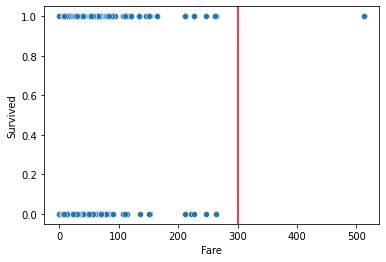

In [ ]:
sns.scatterplot(data=train, x='Fare', y='Survived')
plt.axvline(x=300 , color='r')

In [ ]:
train[train['Fare']>300]['Fare'].count()

3

In [ ]:
train[(train['Fare']>300)][['Fare']]

,Fare
258,512.3292
679,512.3292
737,512.3292


# Drop Exceptions

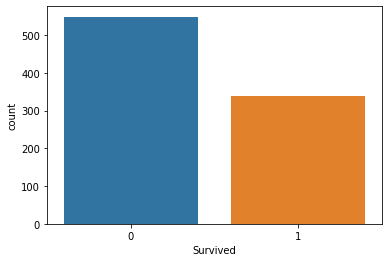

In [ ]:
train=train.drop(train[(train['Fare']>300)].index)
sns.countplot(data=train[train['Fare']<300],x='Survived')

In [ ]:
train[train['Fare']>300]['Fare'].count()

0

# Check Missing Data

In [ ]:
((train.isnull().sum())/len(train))*100

Survived     0.000000
Pclass       0.000000
Name         0.000000
Sex          0.000000
Age         19.932432
SibSp        0.000000
Parch        0.000000
Fare         0.000000
Cabin       77.252252
Embarked     0.225225
dtype: float64

In [ ]:
((test.isnull().sum())/len(test))*100

Pclass       0.000000
Name         0.000000
Sex          0.000000
Age         20.574163
SibSp        0.000000
Parch        0.000000
Fare         0.239234
Cabin       78.229665
Embarked     0.000000
dtype: float64

In [ ]:
#lets fill 0.239% missing fare for test
test["Fare"].fillna(train["Fare"].median(), inplace = True)

based on the missing percentage , we will :
1) fill embarked with most popular value (if there is)

2)  drop cabin because almost 80% are missing , so the value is useless for our model

later , we are going to use Random forest regressor to predict the missing age values. 

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

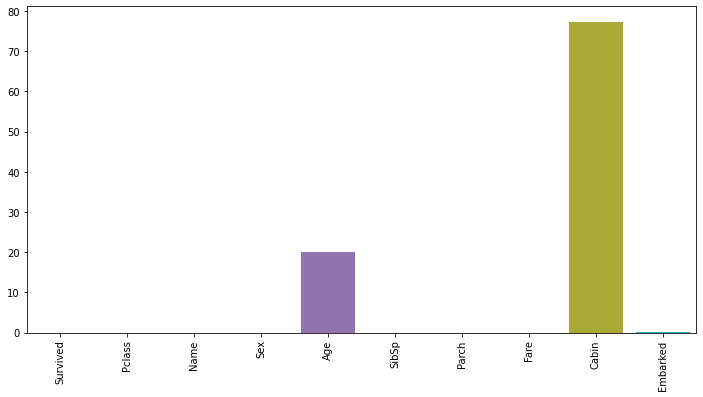

In [ ]:
missing_percent=((train.isnull().sum())/len(train))*100
plt.figure(figsize=(12,6))
sns.barplot(x=missing_percent.index , y=missing_percent)
plt.xticks(rotation=90)

# Clean Data

1)

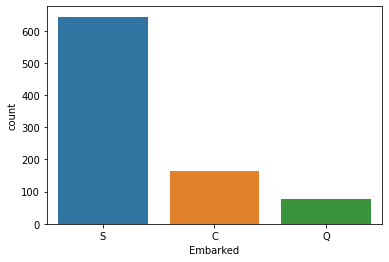

In [ ]:
sns.countplot(data=train,x=train['Embarked'])

In [ ]:
train['Embarked'].value_counts()

S    644
C    165
Q     77
Name: Embarked, dtype: int64

In [ ]:
train['Embarked'].fillna("S", inplace=True) 
test['Embarked'].fillna("S", inplace=True) 
train['Embarked'].value_counts()

S    646
C    165
Q     77
Name: Embarked, dtype: int64

2)

In [ ]:
train.drop('Cabin',axis=1,inplace=True)
test.drop('Cabin',axis=1,inplace=True)

let's see again the status of missing values

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 9 Text major ticklabel objects>)

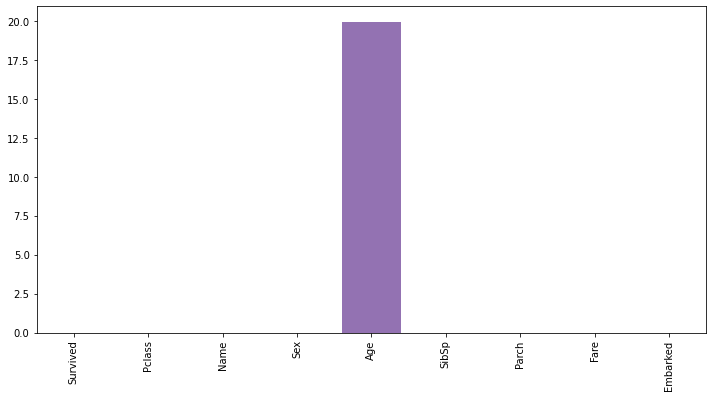

In [ ]:
missing_percent=((train.isnull().sum())/len(train))*100
plt.figure(figsize=(12,6))
sns.barplot(x=missing_percent.index , y=missing_percent)
plt.xticks(rotation=90)

Great! , now we can work on our features , create hyperparameters before we get to training!

# Feature Engineering

we want to create extra features from with in the features that we have, sometimes we want to remove features that are alike. Features engineering is the simple word for doing all those. It is important to remember that we will create new features in such ways that will not cause multicollinearity(when there is a relationship among independent variables)

first we will create a new feature , name_length -> an integer that represents the length of the passenger's name

In [ ]:
# Creating a new colomn with a 
train['name_length'] = [len(i) for i in train.Name]
test['name_length'] = [len(i) for i in test.Name]

def name_length_group(size):
    a = ''
    if (size <=20):
        a = 'short'
    elif (size <=35):
        a = 'medium'
    elif (size <=45):
        a = 'good'
    else:
        a = 'long'
    return a


train['nLength_group'] = train['name_length'].map(name_length_group)
test['nLength_group'] = test['name_length'].map(name_length_group)

check status of train info before we can continue

In [ ]:
train.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 888 entries, 0 to 890
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Survived       888 non-null    int64  
 1   Pclass         888 non-null    int64  
 2   Name           888 non-null    object 
 3   Sex            888 non-null    object 
 4   Age            711 non-null    float64
 5   SibSp          888 non-null    int64  
 6   Parch          888 non-null    int64  
 7   Fare           888 non-null    float64
 8   Embarked       888 non-null    object 
 9   name_length    888 non-null    int64  
 10  nLength_group  888 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 115.5+ KB


In [ ]:
train["title"] = [i.split('.')[0] for i in train.Name]
train["title"] = [i.split(',')[1] for i in train.title]

In [ ]:
train.title.unique()

array([' Mr', ' Mrs', ' Miss', ' Master', ' Don', ' Rev', ' Dr', ' Mme',
       ' Ms', ' Major', ' Lady', ' Sir', ' Mlle', ' Col', ' Capt',
       ' the Countess', ' Jonkheer'], dtype=object)

we now want to replace those titles because some of them have the same meaning.

In [ ]:

train.title = train.title.apply(lambda x: x.strip())
test['title'] = [i.split('.')[0].split(',')[1].strip() for i in test.Name]

In [ ]:
train["title"] = [i.replace('Ms', 'Miss') for i in train.title]
train["title"] = [i.replace('Mlle', 'Miss') for i in train.title]
train["title"] = [i.replace('Mme', 'Mrs') for i in train.title]
train["title"] = [i.replace('Dr', 'rare') for i in train.title]
train["title"] = [i.replace('Col', 'rare') for i in train.title]
train["title"] = [i.replace('Major', 'rare') for i in train.title]
train["title"] = [i.replace('Don', 'rare') for i in train.title]
train["title"] = [i.replace('Jonkheer', 'rare') for i in train.title]
train["title"] = [i.replace('Sir', 'rare') for i in train.title]
train["title"] = [i.replace('Lady', 'rare') for i in train.title]
train["title"] = [i.replace('Capt', 'rare') for i in train.title]
train["title"] = [i.replace('the Countess', 'rare') for i in train.title]
train["title"] = [i.replace('Rev', 'rare') for i in train.title]

In [ ]:
def name_converted(feature):
    """
    This function helps modifying the title column
    """
    
    result = ''
    if feature in ['the Countess','Capt','Lady','Sir','Jonkheer','Don','Major','Col', 'Rev', 'Dona', 'Dr']:
        result = 'rare'
    elif feature in ['Ms', 'Mlle']:
        result = 'Miss'
    elif feature == 'Mme':
        result = 'Mrs'
    else:
        result = feature
    return result

test.title = test.title.map(name_converted)
train.title = train.title.map(name_converted)

In [ ]:
train.title.unique()


array(['Mr', 'Mrs', 'Miss', 'Master', 'rare'], dtype=object)

In [ ]:
test.title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'rare'], dtype=object)

now we will create a new feature , called 'family size' -> length of the passenger's family on the ship

In [ ]:
train['family_size'] = train.SibSp + train.Parch+1
test['family_size'] = test.SibSp + test.Parch+1

In [ ]:
def family_group(size):
    """
    This funciton groups(loner, small, large) family based on family size
    """
    
    a = ''
    if (size <= 1):
        a = 'loner'
    elif (size <= 4):
        a = 'small'
    else:
        a = 'large'
    return a

In [ ]:
train['family_group'] = train['family_size'].map(family_group)
test['family_group'] = test['family_size'].map(family_group)

now lets create a numeric feature for if the passenger is alone or not

In [ ]:
train['is_alone'] = [1 if i<2 else 0 for i in train.family_size]
test['is_alone'] = [1 if i<2 else 0 for i in test.family_size]

now we can add a feature like 'calculated_fare' , since it seems that our data collects fare for a group (family) rather than for an individual , we shall add a feature for that purpose

In [ ]:
train['calculated_fare'] = train.Fare/train.family_size
test['calculated_fare'] = test.Fare/test.family_size

in addition , lets create fare_group , derives from fare

In [ ]:
def fare_group(fare):
    """
    This function creates a fare group based on the fare provided
    """
    
    a= ''
    if fare <= 4:
        a = 'Very_low'
    elif fare <= 10:
        a = 'low'
    elif fare <= 20:
        a = 'mid'
    elif fare <= 45:
        a = 'high'
    else:
        a = "very_high"
    return a

train['fare_group'] = train['calculated_fare'].map(fare_group)
test['fare_group'] = test['calculated_fare'].map(fare_group)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 888 entries, 0 to 890
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Survived         888 non-null    int64  
 1   Pclass           888 non-null    int64  
 2   Name             888 non-null    object 
 3   Sex              888 non-null    object 
 4   Age              711 non-null    float64
 5   SibSp            888 non-null    int64  
 6   Parch            888 non-null    int64  
 7   Fare             888 non-null    float64
 8   Embarked         888 non-null    object 
 9   name_length      888 non-null    int64  
 10  nLength_group    888 non-null    object 
 11  title            888 non-null    object 
 12  family_size      888 non-null    int64  
 13  family_group     888 non-null    object 
 14  is_alone         888 non-null    int64  
 15  calculated_fare  888 non-null    float64
 16  fare_group       888 non-null    object 
dtypes: float64(3), i

as a reminder , we dropped passengerID and Ticket earlier , it seems there is nothing useful we can get from those features.

however , its time to deal with the missing values for column age

In [ ]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,name_length,nLength_group,title,family_size,family_group,is_alone,calculated_fare,fare_group
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,23,medium,Mr,2,small,0,3.62500,Very_low
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,51,long,Mrs,2,small,0,35.64165,high
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,22,medium,Miss,1,loner,1,7.92500,low
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,44,good,Mrs,2,small,0,26.55000,high
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,24,medium,Mr,1,loner,1,8.05000,low


transform label 'Sex' to numeric from categorical

In [ ]:
test['Sex']=test['Sex'].replace({'male':0,'female':1})
train['Sex']=train['Sex'].replace({'male':0,'female':1})

# Creating Dummies

In [ ]:
train = pd.get_dummies(train, columns=['title',"Pclass", 'Embarked','nLength_group', 'family_group', 'fare_group'], drop_first=False)
test = pd.get_dummies(test, columns=['title',"Pclass",'Embarked','nLength_group', 'family_group', 'fare_group'], drop_first=False)
train.drop(['family_size','Name', 'Fare','name_length'], axis=1, inplace=True)
test.drop(['Name','family_size',"Fare",'name_length'], axis=1, inplace=True)

In [ ]:
train.head()

,Survived,Sex,Age,SibSp,Parch,is_alone,calculated_fare,title_Master,title_Miss,title_Mr,...,nLength_group_medium,nLength_group_short,family_group_large,family_group_loner,family_group_small,fare_group_Very_low,fare_group_high,fare_group_low,fare_group_mid,fare_group_very_high
0,0,0,22.0,1,0,0,3.62500,0,0,1,...,1,0,0,0,1,1,0,0,0,0
1,1,1,38.0,1,0,0,35.64165,0,0,0,...,0,0,0,0,1,0,1,0,0,0
2,1,1,26.0,0,0,1,7.92500,0,1,0,...,1,0,0,1,0,0,0,1,0,0
3,1,1,35.0,1,0,0,26.55000,0,0,0,...,0,0,0,0,1,0,1,0,0,0
4,0,0,35.0,0,0,1,8.05000,0,0,1,...,1,0,0,1,0,0,0,1,0,0


In [ ]:
## rearranging the columns so that I can easily use the dataframe to predict the missing age values. 
train = pd.concat([train[["Survived", "Age", "Sex","SibSp","Parch"]], train.loc[:,"is_alone":]], axis=1)
test = pd.concat([test[["Age", "Sex"]], test.loc[:,"SibSp":]], axis=1)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 888 entries, 0 to 890
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Survived              888 non-null    int64  
 1   Age                   711 non-null    float64
 2   Sex                   888 non-null    int64  
 3   SibSp                 888 non-null    int64  
 4   Parch                 888 non-null    int64  
 5   is_alone              888 non-null    int64  
 6   calculated_fare       888 non-null    float64
 7   title_Master          888 non-null    uint8  
 8   title_Miss            888 non-null    uint8  
 9   title_Mr              888 non-null    uint8  
 10  title_Mrs             888 non-null    uint8  
 11  title_rare            888 non-null    uint8  
 12  Pclass_1              888 non-null    uint8  
 13  Pclass_2              888 non-null    uint8  
 14  Pclass_3              888 non-null    uint8  
 15  Embarked_C            8

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   332 non-null    float64
 1   Sex                   418 non-null    int64  
 2   SibSp                 418 non-null    int64  
 3   Parch                 418 non-null    int64  
 4   is_alone              418 non-null    int64  
 5   calculated_fare       418 non-null    float64
 6   title_Master          418 non-null    uint8  
 7   title_Miss            418 non-null    uint8  
 8   title_Mr              418 non-null    uint8  
 9   title_Mrs             418 non-null    uint8  
 10  title_rare            418 non-null    uint8  
 11  Pclass_1              418 non-null    uint8  
 12  Pclass_2              418 non-null    uint8  
 13  Pclass_3              418 non-null    uint8  
 14  Embarked_C            418 non-null    uint8  
 15  Embarked_Q            4

In [ ]:
## Importing RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

## writing a function that takes a dataframe with missing values and outputs it by filling the missing values. 
def completing_age(df):
    ## gettting all the features except survived
    age_df = df.loc[:,"Age":] 
    
    temp_train = age_df.loc[age_df.Age.notnull()] ## df with age values
    temp_test = age_df.loc[age_df.Age.isnull()] ## df without age values
 
    
    y = temp_train.Age.values ## setting target variables(age) in y 
    x = temp_train.loc[:, "Sex":].values
    
    rfr = RandomForestRegressor(n_estimators=1500, n_jobs=-1)
    rfr.fit(x, y)
    
    predicted_age = rfr.predict(temp_test.loc[:, "Sex":])
    
    df.loc[df.Age.isnull(), "Age"] = predicted_age
    

    return df

## Implementing the completing_age function in both train and test dataset. 
completing_age(train)
completing_age(test)



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


,Age,Sex,SibSp,Parch,is_alone,calculated_fare,title_Master,title_Miss,title_Mr,title_Mrs,...,nLength_group_medium,nLength_group_short,family_group_large,family_group_loner,family_group_small,fare_group_Very_low,fare_group_high,fare_group_low,fare_group_mid,fare_group_very_high
0,34.500000,0,0,0,1,7.829200,0,0,1,0,...,0,1,0,1,0,0,0,1,0,0
1,47.000000,1,1,0,0,3.500000,0,0,0,1,...,1,0,0,0,1,1,0,0,0,0
2,62.000000,0,0,0,1,9.687500,0,0,1,0,...,1,0,0,1,0,0,0,1,0,0
3,27.000000,0,0,0,1,8.662500,0,0,1,0,...,0,1,0,1,0,0,0,1,0,0
4,22.000000,1,1,1,0,4.095833,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,23.211060,0,0,0,1,8.050000,0,0,1,0,...,0,1,0,1,0,0,0,1,0,0
414,39.000000,1,0,0,1,108.900000,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1
415,38.500000,0,0,0,1,7.250000,0,0,1,0,...,1,0,0,1,0,0,0,1,0,0
416,23.211060,0,0,0,1,8.050000,0,0,1,0,...,0,1,0,1,0,0,0,1,0,0


lets create a new feature age_group that derives from age

In [ ]:
def age_group_fun(age):
    """
    This function creates a bin for age
    """
    a = ''
    if age <= 1:
        a = 'infant'
    elif age <= 4: 
        a = 'toddler'
    elif age <= 13:
        a = 'child'
    elif age <= 18:
        a = 'teenager'
    elif age <= 35:
        a = 'Young_Adult'
    elif age <= 45:
        a = 'adult'
    elif age <= 55:
        a = 'middle_aged'
    elif age <= 65:
        a = 'senior_citizen'
    else:
        a = 'old'
    return a
        
## Applying "age_group_fun" function to the "Age" column.
train['age_group'] = train['Age'].map(age_group_fun)
test['age_group'] = test['Age'].map(age_group_fun)

## Creating dummies for "age_group" feature. 
train = pd.get_dummies(train,columns=['age_group'], drop_first=True)
test = pd.get_dummies(test,columns=['age_group'], drop_first=True);

# Pre modeling

In [ ]:
X = train.drop(['Survived'], axis = 1)
y = train["Survived"]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = .33, random_state=42)

# Feature Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler
st_scale = StandardScaler()

## transforming "train_x"
X_train = st_scale.fit_transform(X_train)
## transforming "test_x"
X_test = st_scale.transform(X_test)


# Modeling

In [ ]:
# import LogisticRegression model in python. 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, accuracy_score

## call on the model object
logreg = LogisticRegression(solver='liblinear',
                            penalty= 'l1',random_state = 42
                                
                            )

## fit the model with "train_x" and "train_y"
logreg.fit(X_train,y_train)

## Once the model is trained we want to find out how well the model is performing, so we test the model. 
## we use "X_test" portion of the data(this data was not used to fit the model) to predict model outcome. 
y_pred = logreg.predict(X_test)

# Evaluation

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
# printing confision matrix
pd.DataFrame(confusion_matrix(y_test,y_pred),\
            columns=["Predicted Not-Survived", "Predicted Survived"],\
            index=["Not-Survived","Survived"] )

,Predicted Not-Survived,Predicted Survived
Not-Survived,151,25
Survived,18,100


In [ ]:
from sklearn.metrics import accuracy_score  #accuracy
accuracy_score(y_test, y_pred)

0.8537414965986394

In [ ]:
from sklearn.metrics import recall_score  #recall
recall_score(y_test, y_pred)

0.847457627118644

In [ ]:
from sklearn.metrics import precision_score   #precision
precision_score(y_test, y_pred)

0.8

In [ ]:
from sklearn.metrics import classification_report, balanced_accuracy_score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.86      0.88       176
           1       0.80      0.85      0.82       118

    accuracy                           0.85       294
   macro avg       0.85      0.85      0.85       294
weighted avg       0.86      0.85      0.85       294



# Cross validation

we will use cross validation in order to:
try to reduce variance and expand our model's predictability.

In [ ]:
sc = st_scale

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
cv = StratifiedShuffleSplit(n_splits = 10, test_size = .25, random_state = 0 ) 
## Using standard scale for the whole dataset.

## saving the feature names for decision tree display
column_names = X.columns

X = sc.fit_transform(X)
accuracies = cross_val_score(LogisticRegression(solver='liblinear'), X,y, cv  = cv)
print ("Cross-Validation accuracy scores:{}".format(accuracies))
print ("Mean Cross-Validation accuracy score: {}".format(round(accuracies.mean(),5)))

Cross-Validation accuracy scores:[0.81981982 0.84684685 0.82432432 0.85135135 0.85585586 0.82432432
 0.81081081 0.86036036 0.83783784 0.81531532]
Mean Cross-Validation accuracy score: 0.83468


# Grid Search on LR

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
## C_vals is the alpla value of lasso and ridge regression(as alpha increases the model complexity decreases,)
C_vals = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5,6,7,8,9,10,12,13,14,15,16,16.5,17,17.5,18]
## Choosing penalties(Lasso(l1) or Ridge(l2))
penalties = ['l1','l2']
## Choose a cross validation strategy. 
cv = StratifiedShuffleSplit(n_splits = 10, test_size = .25)

## setting param for param_grid in GridSearchCV. 
param = {'penalty': penalties, 'C': C_vals}

logreg = LogisticRegression(solver='liblinear')
## Calling on GridSearchCV object. 
grid = GridSearchCV(estimator=LogisticRegression(), 
                           param_grid = param,
                           scoring = 'accuracy',
                            n_jobs =-1,
                           cv = cv
                          )
## Fitting the model
grid.fit(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
270 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
270 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Sol

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=None, test_size=0.25,
            train_size=None),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3,
                               4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 16.5,
                               17, 17.5, 18],
                         'penalty': ['l1', 'l2']},
             scoring='accuracy')

In [ ]:
print (grid.best_score_)
print (grid.best_params_)
print(grid.best_estimator_)

0.8292792792792794
{'C': 1, 'penalty': 'l2'}
LogisticRegression(C=1)


lets use the best out of our grid search

In [ ]:
logreg_grid = grid.best_estimator_
logreg_grid.score(X,y)

0.838963963963964

# Decision Tree Classifier


In [ ]:
from sklearn.tree import DecisionTreeClassifier
max_depth = range(1,30)
max_feature = [21,22,23,24,25,26,28,29,30,'auto']
criterion=["entropy", "gini"]

param = {'max_depth':max_depth, 
         'max_features':max_feature, 
         'criterion': criterion}
grid = GridSearchCV(DecisionTreeClassifier(), 
                                param_grid = param, 
                                 verbose=False, 
                                 cv=StratifiedKFold(n_splits=20, random_state=15, shuffle=True),
                                n_jobs = -1)
grid.fit(X, y) 

GridSearchCV(cv=StratifiedKFold(n_splits=20, random_state=15, shuffle=True),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': range(1, 30),
                         'max_features': [21, 22, 23, 24, 25, 26, 28, 29, 30,
                                          'auto']},
             verbose=False)

In [ ]:
print( grid.best_params_)
print (grid.best_score_)
print (grid.best_estimator_)

{'criterion': 'entropy', 'max_depth': 4, 'max_features': 29}
0.8402272727272727
DecisionTreeClassifier(criterion='entropy', max_depth=4, max_features=29)


In [ ]:
dectree_grid = grid.best_estimator_
## using the best found hyper paremeters to get the score. 
dectree_grid.score(X,y)

0.8490990990990991

lets look at the importance of features from decision tree grid

In [ ]:
feature_importances = pd.DataFrame(dectree_grid.feature_importances_,
                                   index = column_names,
                                    columns=['importance'])
feature_importances.sort_values(by='importance', ascending=False).head(10)

,importance
title_Mr,0.561365
calculated_fare,0.192134
family_group_large,0.129091
fare_group_low,0.046763
title_rare,0.041057
age_group_senior_citizen,0.014146
Age,0.010457
nLength_group_short,0.004987
age_group_old,0.000000
age_group_middle_aged,0.000000


# Random Forest Classifier
RF is an ensemble method (combination of many decision trees) which is where the "forest" part comes in. One crucial details about Random Forest is that while using a forest of decision trees, RF model takes random subsets of the original dataset(bootstrapped) and random subsets of the variables(features/columns). Using this method, the RF model creates a wide and large variety of decision trees. This variety makes the RF model more effective and accurate. We then run each test data point through all of these  decision trees or the RF model and take a vote on the output.

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
n_estimators = [140,145,150,155,160];
max_depth = range(1,10);
criterions = ['gini', 'entropy'];
cv = StratifiedShuffleSplit(n_splits=10, test_size=.30, random_state=42)


parameters = {'n_estimators':n_estimators,
              'max_depth':max_depth,
              'criterion': criterions
              
        }
grid = GridSearchCV(estimator=RandomForestClassifier(max_features='auto'),
                                 param_grid=parameters,
                                 cv=cv,
                                 n_jobs = -1)
grid.fit(X,y) 

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.3,
            train_size=None),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 10),
                         'n_estimators': [140, 145, 150, 155, 160]})

In [ ]:
print (grid.best_score_)
print (grid.best_params_)
print (grid.best_estimator_)

0.8310861423220974
{'criterion': 'gini', 'max_depth': 7, 'n_estimators': 150}
RandomForestClassifier(max_depth=7, n_estimators=150)


In [ ]:
rf_grid = grid.best_estimator_
rf_grid.score(X,y)

0.8918918918918919

In [ ]:
from sklearn.metrics import classification_report
# Print classification report for y_test
print(classification_report(y_test, y_pred, labels=rf_grid.classes_))

              precision    recall  f1-score   support

           0       0.89      0.86      0.88       176
           1       0.80      0.85      0.82       118

    accuracy                           0.85       294
   macro avg       0.85      0.85      0.85       294
weighted avg       0.86      0.85      0.85       294



# Baggging Classifier
Bagging classifier uses a process called bootstrapped dataset to create multiple datasets from one original dataset and runs algorithm on each one of them. Here is an image to show how bootstrapped dataset works.

In [ ]:
from sklearn.ensemble import BaggingClassifier
n_estimators = [10,30,50,70,80,150,160, 170,175,180,185];
cv = StratifiedShuffleSplit(n_splits=10, test_size=.30, random_state=15)

parameters = {'n_estimators':n_estimators,
              
        }
grid = GridSearchCV(BaggingClassifier(base_estimator= None, ## If None, then the base estimator is a decision tree.
                                      bootstrap_features=False),
                                 param_grid=parameters,
                                 cv=cv,
                                 n_jobs = -1)
grid.fit(X,y) 

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=15, test_size=0.3,
            train_size=None),
             estimator=BaggingClassifier(), n_jobs=-1,
             param_grid={'n_estimators': [10, 30, 50, 70, 80, 150, 160, 170,
                                          175, 180, 185]})

once again...

In [ ]:
print (grid.best_score_)
print (grid.best_params_)
print (grid.best_estimator_)

0.8153558052434458
{'n_estimators': 180}
BaggingClassifier(n_estimators=180)


In [ ]:
bagging_grid = grid.best_estimator_
bagging_grid.score(X,y)

0.9876126126126126

# Prepare to submit results
we are going to predict with each model 
and eventually pick the one with the highest score

In [ ]:
all_models = [logreg_grid,
              dectree_grid,
              rf_grid,
              bagging_grid]

c = {}
for i in all_models:
    a = i.predict(X_test)
    b = accuracy_score(a, y_test)
    c[i] = b
    

In [ ]:
print(c)

{LogisticRegression(C=1): 0.8537414965986394, DecisionTreeClassifier(criterion='entropy', max_depth=4, max_features=29): 0.8469387755102041, RandomForestClassifier(max_depth=7, n_estimators=150): 0.8741496598639455, BaggingClassifier(n_estimators=180): 0.9217687074829932}


In [ ]:
max(c, key=c.get)

BaggingClassifier(n_estimators=180)

In [ ]:
test_prediction = (max(c, key=c.get)).predict(test)
submission = pd.DataFrame({
        "PassengerId": id_col,
        "Survived": test_prediction
    })

submission.PassengerId = submission.PassengerId.astype(int)
submission.Survived = submission.Survived.astype(int)

submission.to_csv("final_submission.csv", index=False)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but BaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
